### build dataset

In [610]:
import csv
from pathlib import Path
import numpy as np
import tensorflow as tf
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
import math

def expand_row_data(data, capture_point) -> tuple[np.ndarray, np.ndarray]:

    label = []
    expand_data = []

    for idx in range(1, len(data), capture_point):
        label.append(int(data[0]))
        expand_data.append(np.array(data[idx : idx + capture_point]))

    return label, expand_data

def gen_tf_dataset(data, capture_point, batch_size, output_class):
    label = []
    expanded_data = []
    for row in data:
        l, e = expand_row_data(row, capture_point)    
        
        label += l
        expanded_data += e
    label = tf.one_hot(label, output_class)  
    
    dataset = tf.data.Dataset.from_tensor_slices((expanded_data, label))
    dataset = dataset.shuffle(len(data), reshuffle_each_iteration=True)
    dataset = dataset.cache()
    dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(tf.data.AUTOTUNE)
    return dataset

def dataset_preproccessed(data_folder, batch_size, train_vaild_test_ratio, output_class):
    data_folder = Path(data_folder)
    capture_point, extra_point = data_folder.stem.split('_')[:-1]
    capture_point = int(capture_point[1:])
    extra_point = int(extra_point[1:])

    
    with open(data_folder, newline='') as data:
        row_data = csv.reader(data, delimiter=',')
        row_data = [i for i in row_data]

    random.shuffle(row_data)
    
    train_data_cnt = int(len(row_data) * train_vaild_test_ratio[0])
    valid_data_cnt = int(len(row_data) * train_vaild_test_ratio[1])
    test_data_cnt = len(row_data) - train_data_cnt - valid_data_cnt
    print(capture_point, extra_point)
    print(train_data_cnt, valid_data_cnt, test_data_cnt)
    
    for idx, row in enumerate(row_data):
        for c_idx, _ in enumerate(row): row[c_idx] = int(row[c_idx])

    train_dataset = gen_tf_dataset(row_data[:train_data_cnt], capture_point, batch_size, output_class)
    valid_dataset = gen_tf_dataset(row_data[train_data_cnt : train_data_cnt + valid_data_cnt], capture_point, batch_size, output_class)
    test_dataset = gen_tf_dataset(row_data[train_data_cnt + valid_data_cnt : ], capture_point, batch_size, output_class)
    
    return capture_point, train_dataset, valid_dataset, test_dataset




### pseudo dataset

In [611]:
def gen_pseudo_dataset(size, capture_point, batch_size, output_class):
    label = []
    expanded_data = []

    x_values = np.random.uniform(low=0, high= output_class * 1000, size=size).astype(np.float32)

    for x in x_values:
        l = int(x // 1000) 

        e = [l for i in range(capture_point)]

        label += [l]
        expanded_data += [e]
    label = tf.one_hot(label, output_class)  
    
    dataset = tf.data.Dataset.from_tensor_slices((expanded_data, label))
    dataset = dataset.shuffle(size, reshuffle_each_iteration=True)
    dataset = dataset.cache()
    dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(tf.data.AUTOTUNE)
    return dataset

def pseudo_dataset_preproccessed(total_data_size ,capture_point, batch_size, train_vaild_test_ratio, output_class):

    
    train_data_cnt = int(total_data_size * train_vaild_test_ratio[0])
    valid_data_cnt = int(total_data_size * train_vaild_test_ratio[1])
    test_data_cnt = total_data_size- train_data_cnt - valid_data_cnt
    print(capture_point)
    print(train_data_cnt, valid_data_cnt, test_data_cnt)

    train_dataset = gen_pseudo_dataset(train_data_cnt, capture_point, batch_size, output_class)
    valid_dataset = gen_pseudo_dataset(valid_data_cnt, capture_point, batch_size, output_class)
    test_dataset = gen_pseudo_dataset(test_data_cnt, capture_point, batch_size, output_class)
    
    return capture_point, train_dataset, valid_dataset, test_dataset

### define model

In [612]:
class model(tf.keras.Model):
    def __init__(self , input_dim , out_class = 9 , learning_rate=1e-3):
        super().__init__()
        self.input_dim = input_dim
        self.out_class = out_class
        self.learning_rate = learning_rate

        self._model = self._build_model()
        self._learner = self._build_learner()
    
    @tf.function
    def call(self, x:tf.Tensor, training:bool=False) -> tf.Tensor:
        output = self._model(x, training=training)
        return output
    
    @tf.function
    def train(self, x:tf.Tensor, y:tf.Tensor):
        with tf.GradientTape() as tape:
            output = self.__call__(x, training=True)
            classLoss = self._learner["get_loss"](y, output)
            review = tf.math.in_top_k(tf.math.argmax(y,axis=1), output, 1)
            perf = tf.math.reduce_mean(tf.cast(review, dtype="float32"))

        cGradients = tape.gradient(classLoss, self._model.trainable_variables)
        self._learner["optimize"].apply_gradients(zip(cGradients, self._model.trainable_variables))
        return perf, classLoss


    @tf.function
    def validate(self, x:tf.Tensor, y:tf.Tensor) -> tf.Tensor:
        output = self.__call__(x, training=False)
        classLoss = self._learner["get_loss"](y , output)
        review = tf.math.in_top_k(tf.math.argmax(y,axis=1), output, 1)
        perf = tf.math.reduce_mean(tf.cast(review, dtype="float32"))
        return perf , classLoss

    def _build_model(self) -> tf.keras.Model:

        input_tensor = tf.keras.Input(shape=self.input_dim)
        feature_map = input_tensor
        
        d = 32
        feature_map = tf.keras.layers.Dense(d, input_dim = self.input_dim, activation='relu')(feature_map)
        # feature_map = tf.keras.layers.Dropout(0.2)(feature_map)
        # feature_map = tf.keras.layers.Dense(d, input_dim = d, activation='relu')(feature_map)
        # feature_map = tf.keras.layers.Dropout(0.2)(feature_map)
        # feature_map = tf.keras.layers.Dense(512, input_dim = 512, activation='relu')(feature_map)
        output_tensor = tf.keras.layers.Dense(self.out_class, input_dim = d, activation=tf.keras.activations.softmax)(feature_map)
        

        model = tf.keras.Model(input_tensor, output_tensor)
        return model
    
    def _build_learner(self) -> dict:
        # classLoss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
        classLoss = tf.keras.losses.CategoricalCrossentropy()
        classOptimizer = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)
        learner = {"get_loss": classLoss, "optimize": classOptimizer}

        return learner

### train

In [613]:
def train_one_epoch(model , train_dataloader , valid_dataloader , max_acc , root_dir : Path):

    epoch_train_loss = []
    epoch_train_acc = []
    epoch_valid_loss = []
    epoch_valid_acc = []

    for inData, outData in tqdm(train_dataloader):
        acc , loss = model.train(inData, outData)
        epoch_train_acc.append(acc)
        epoch_train_loss.append(loss)
        # print(loss)
        # print(acc)
    # raise ValueError
        
    for inData, outData in tqdm(valid_dataloader):
        acc , loss = model.validate(inData, outData)
        epoch_valid_acc.append(acc)
        epoch_valid_loss.append(loss)

    epoch_train_acc_mean = tf.math.reduce_mean(epoch_train_acc) * 100
    epoch_valid_acc_mean = tf.math.reduce_mean(epoch_valid_acc) * 100
    epoch_train_loss_mean = tf.math.reduce_mean(epoch_train_loss)
    epoch_valid_loss_mean = tf.math.reduce_mean(epoch_valid_loss)

    print(f"  Train Acc: {epoch_train_acc_mean:.2f}, Loss: {epoch_train_loss_mean:.2f}")
    print(f"  Valid Acc: {epoch_valid_acc_mean:.2f}, Loss: {epoch_valid_loss_mean:.2f}")

    if(epoch_valid_acc_mean > max_acc):
        print("save best model")
        model.save(root_dir /"model", include_optimizer=False)
    
    return epoch_train_acc_mean, epoch_train_loss_mean , epoch_valid_acc_mean , epoch_valid_loss_mean


In [614]:
def testing_model(test_dataloader , root_dir : Path = None , model_path : Path = None):
    if root_dir is not None :
        model = tf.keras.models.load_model(root_dir / "model", compile=False)
    elif model_path is not None:
        model = tf.keras.models.load_model(model_path)
    else:
        raise AttributeError("Testing models root_dir and model_path are not given")
    
    testing_acc = []
    print("Testing Model")
    
    for data , label in tqdm(test_dataloader):
        acc , loss = model.validate(data , label)
        
        testing_acc.append(acc)
    
    print(f"acc = {np.mean(testing_acc)*100:.2f}")
    del model

In [615]:
def show_train_results(train_info , root_folder : Path):
    train_info = np.array(train_info)

    plt.plot(np.arange(1,train_info.shape[0]+1) , train_info[:,0] , 'r' , label='train')
    plt.plot(np.arange(1,train_info.shape[0]+1) , train_info[:,2] , 'b' , label='valid')
    plt.title("Acc")
    plt.savefig(root_folder / "model" / "Acc.png")
    plt.show()

    plt.plot(np.arange(1,train_info.shape[0]+1) , train_info[:,1] , 'r' , label='train')
    plt.plot(np.arange(1,train_info.shape[0]+1) , train_info[:,3] , 'b' , label='valid')
    plt.title("Loss")
    plt.savefig(root_folder / "model" / "Loss.png")
    plt.show()

### convert model

In [616]:
def save_model_tflite_quant(save_model_folder : Path , dataset):

    def representative_dataset():
        idx = 0
        for data , label in dataset:
            # if idx > 1000:
            #     break
            # idx += 1
            
            yield [data]

    # float
    converter = tf.lite.TFLiteConverter.from_saved_model(str(save_model_folder))
    tflite_model = converter.convert()
    open(save_model_folder / 'float_model.tflite', 'wb').write(tflite_model)
    print("Successfully convert tflite float")

    # quant
    converter = tf.lite.TFLiteConverter.from_saved_model(str(save_model_folder))
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    converter.representative_dataset = representative_dataset
    converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
    converter.inference_input_type = tf.int8  # or tf.uint8
    converter.inference_output_type = tf.int8  # or tf.uint8
    tflite_quant_model = converter.convert()
    open(save_model_folder / 'quant_model.tflite', 'wb').write(tflite_quant_model)
    print("Successfully convert tflite quant")

In [617]:
def test_tflite_model(tflite_model_path, test_dataset):
    interpreter = tf.lite.Interpreter(model_path=str(tflite_model_path))
    interpreter.allocate_tensors()
    input = interpreter.get_input_details()[0]
    output = interpreter.get_output_details()[0]
    input_scale, input_zero_point = input['quantization']
    output_scale, output_zero_point = output["quantization"]
    
    print(f"testing with {tflite_model_path}")
    
    testing_acc = np.array([])
    for data , label in tqdm(test_dataset):
        if input["dtype"] == np.float32:
            interpreter.set_tensor(input['index'], data)
        else:
            quant_data = data.numpy() / input_scale + input_zero_point
            interpreter.set_tensor(input['index'], quant_data.astype(input["dtype"] ))

        interpreter.invoke()

        if output["dtype"] == np.float32:
            pred = interpreter.get_tensor(output['index'])
        else:
            dequant_pred = interpreter.get_tensor(output['index']).astype(np.float32)
            pred = (dequant_pred - output_zero_point) * output_scale

        testing_acc = np.append(testing_acc, np.argmax(pred) == np.argmax(label))   
    
    print(f"result acc = {np.mean(testing_acc)*100:.2f}")


### main func

15
2700 150 150
Model: "model_159"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_80 (InputLayer)       [(None, 15)]              0         
                                                                 
 dense_191 (Dense)           (None, 32)                512       
                                                                 
 dense_192 (Dense)           (None, 10)                330       
                                                                 
Total params: 842 (3.29 KB)
Trainable params: 842 (3.29 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


100%|██████████| 2/2 [00:00<00:00, 28.09it/s]


  Train Acc: 10.23, Loss: 3.10
  Valid Acc: 7.81, Loss: 2.25
save best model
INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets
100%|██████████| 2/2 [00:00<00:00, 500.24it/s]

  Train Acc: 10.27, Loss: 2.18
  Valid Acc: 14.06, Loss: 2.07
save best model


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets
100%|██████████| 2/2 [00:00<00:00, 556.46it/s]


  Train Acc: 9.78, Loss: 2.11
  Valid Acc: 14.06, Loss: 2.04


100%|██████████| 2/2 [00:00<00:00, 491.34it/s]


  Train Acc: 9.97, Loss: 2.09
  Valid Acc: 14.06, Loss: 2.03


100%|██████████| 2/2 [00:00<00:00, 498.02it/s]


  Train Acc: 9.97, Loss: 2.07
  Valid Acc: 14.06, Loss: 2.01


100%|██████████| 2/2 [00:00<00:00, 524.12it/s]


  Train Acc: 10.04, Loss: 2.05
  Valid Acc: 14.06, Loss: 2.00


100%|██████████| 2/2 [00:00<00:00, 517.66it/s]


  Train Acc: 9.93, Loss: 2.03
  Valid Acc: 14.06, Loss: 1.98


100%|██████████| 2/2 [00:00<00:00, 492.64it/s]


  Train Acc: 9.93, Loss: 2.01
  Valid Acc: 14.06, Loss: 1.96


100%|██████████| 2/2 [00:00<00:00, 477.58it/s]


  Train Acc: 10.23, Loss: 2.00
  Valid Acc: 14.06, Loss: 1.95


100%|██████████| 2/2 [00:00<00:00, 523.08it/s]


  Train Acc: 10.04, Loss: 1.98
  Valid Acc: 14.06, Loss: 1.93


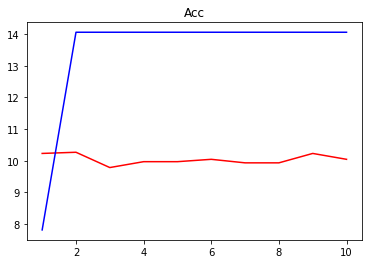

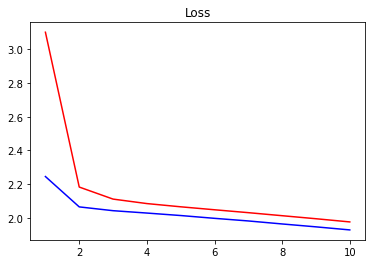

Testing Model


100%|██████████| 2/2 [00:00<00:00, 48.78it/s]


acc = 8.59


2024-06-01 22:47:20.361682: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-06-01 22:47:20.361715: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-06-01 22:47:20.361949: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: model
2024-06-01 22:47:20.364209: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-06-01 22:47:20.364226: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: model
2024-06-01 22:47:20.369153: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-06-01 22:47:20.403915: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: model
2024-06-01 22:47:20.417447: I tensorflow/cc/saved_model/loader.cc:316] SavedModel load for tags { serve }; Status: success: OK. Took 55499 microseconds.
Summary on the non-c

Successfully convert tflite float


2024-06-01 22:47:20.835116: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-06-01 22:47:20.835145: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-06-01 22:47:20.835366: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: model
2024-06-01 22:47:20.837492: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-06-01 22:47:20.837510: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: model
2024-06-01 22:47:20.842315: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-06-01 22:47:20.876763: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: model
2024-06-01 22:47:20.890107: I tensorflow/cc/saved_model/loader.cc:316] SavedModel load for tags { serve }; Status: success: OK. Took 54741 microseconds.
Summary on the non-c

Successfully convert tflite quant
15
10 10 980
testing with model/float_model.tflite


  0%|          | 0/980 [00:00<?, ?it/s]/tmp/ipykernel_20426/139571656.py:16: RuntimeWarning: divide by zero encountered in divide
  quant_data = data.numpy() / input_scale + input_zero_point
/tmp/ipykernel_20426/139571656.py:17: RuntimeWarning: invalid value encountered in cast
  interpreter.set_tensor(input['index'], quant_data.astype(input["dtype"] ))
/tmp/ipykernel_20426/139571656.py:16: RuntimeWarning: invalid value encountered in divide
  quant_data = data.numpy() / input_scale + input_zero_point
100%|██████████| 980/980 [00:00<00:00, 2750.46it/s]


result acc = 8.06
testing with model/quant_model.tflite


100%|██████████| 980/980 [00:00<00:00, 2692.39it/s]


result acc = 10.61


In [618]:
batch_size = 64
learning_rate = 1e-3
epochs = 10

output_class = 10
save_dir = Path("./")
# input_shape, train_dataset, valid_dataset, test_dataset = dataset_preproccessed("../c3_e3_dataset.csv", batch_size, [0.9, 0.05, 0.05], output_class)
input_shape, train_dataset, valid_dataset, test_dataset = pseudo_dataset_preproccessed(3000, 15, batch_size, [0.9, 0.05, 0.05], output_class)

m = model([input_shape], output_class, learning_rate)
m.build((batch_size , input_shape))
m._model.summary()

train_info = []
max_acc = 0
for epoch in range(epochs):
    epoch_info = train_one_epoch(m, train_dataset, valid_dataset, max_acc, save_dir)
    max_acc = max(epoch_info[2], max_acc)
    train_info.append(list(epoch_info))

show_train_results(train_info , save_dir)
testing_model(test_dataset, save_dir, save_dir)
save_model_tflite_quant(save_dir / "model", valid_dataset)

input_shape, train_dataset, valid_dataset, test_dataset = pseudo_dataset_preproccessed(1000, 15, 1, [0.01, 0.01, 0.98], output_class)
test_tflite_model(save_dir / "model" / "float_model.tflite", test_dataset)
test_tflite_model(save_dir / "model" / "quant_model.tflite", test_dataset)

!xxd -i {save_dir}/model/quant_model.tflite > model/model.cc
!echo -ne "#include \"model_data_quant.h\"\nalignas(8)\n" > model/model_data_quant.cc
!cat model/model.cc >> model/model_data_quant.cc
!sed -i -E 's/(unsigned\s.*\s).*(_len|\[\])/const \1model\2/g' model/model_data_quant.cc
     